## The goal of this notebook is to give a quick walkthrough of the core code that is used in the virtual try on projec

In [1]:
import h5py
import matlab.engine
import cv2
import json
import os
import sys
sys.path.append('./cp_vton')
sys.path.append('./LIP_JPPNet')
from LIP_JPPNet.evaluate_parsing_JPPNet import *
from cp_vton.test import *

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



## Setting Inital Parameters and Options required to run the model

In [7]:
FINE_HEIGHT = 256
FINE_WIDTH = 192
POINT_NUM = 18

In [8]:
class opt():
    def __init__(self, name, stage, data_path, imname, cname, result_dir, checkpoint):
        self.name = name
        self.gpu_ids = ""
        self.workers = 0
        self.batch_size = 4
        self.data_path = data_path
        self.stage = stage
        self.imname = imname
        self.cname = cname
        self.fine_width = 192
        self.fine_height = 256
        self.radius = 5
        self.grid_size = 5
        self.grid_image = 'cp_vton/grid.png'
        self.result_dir = result_dir
        self.checkpoint = checkpoint
        self.shuffle = False

In [9]:
def create_dir(target_root_dir):
    if not os.path.exists(target_root_dir):
        os.makedirs(target_root_dir)
    dir_list = ['cloth', 'cloth-mask', 'image', 'image-parse', 'pose']
    for dir in dir_list:
        full_dir = os.path.join(target_root_dir, dir)
        if not os.path.exists(full_dir):
            os.makedirs(full_dir)


## Code to run matlab code. The Matlab code creates bilinear interpolation of the images. This will help strech the images to the same size so as to help fit the clothing on the image better

In [10]:
def run_mat(source_root_dir, target_root_dir, imname, cname):
    eng = matlab.engine.start_matlab()
    eng.convert_data(source_root_dir, target_root_dir, imname, cname, FINE_HEIGHT, FINE_WIDTH)
    eng.quit()

## OpenPose creates the keypoints for a given image. That is, openpose detects and maps each of the body parts to a predetermined set of ordered pairs. This is output as JSON. The JSON based file is read and converted to measurements according to the image at hand

In [11]:
def convert_keypoints(source_root_dir, target_root_dir, imname):
        # load image
        im = cv2.imread(source_root_dir + 'image/' + imname)
        h = im.shape[0]
        w = im.shape[1]
        # load keypoints
        key_name = imname[:-4] + '_keypoints.json'
        with open(source_root_dir + 'pose/' + key_name, 'r') as rf:
            pose = json.load(rf)
        key_points = pose['people'][0]['pose_keypoints_2d']

        for i in range(POINT_NUM):
            key_points[3 * i] = key_points[3 * i] / w * FINE_WIDTH
            key_points[3 * i + 1] = key_points[3 * i + 1] / h * FINE_HEIGHT

        pose = {"version": 1.0, "people": [
            {"face_keypoints": [], "pose_keypoints": key_points, "hand_right_keypoints": [],
             "hand_left_keypoints": []}]}
        with open(target_root_dir + 'pose/' + key_name, 'w') as wf:
            json.dump(pose, wf)

## Setting the source and destination directory to pre-existing samples  

In [13]:
source_root_dir='data/raw_data/'
target_root_dir='data/test/'
imname='model_to_dress.jpg'
cname='blue-shirt.jpg'    

## Run the OpenPose code to generate the required key point json file for the test file

In [15]:
# get pose
os.system("OpenPose\\bin\OpenPoseDemo.exe --image_dir data\image\\ --model_folder OpenPose\models")
create_dir(target_root_dir)

## Convert it to accomadate the image at hand

In [16]:
print("Converting keypoints")
convert_keypoints(source_root_dir, target_root_dir, imname)

Converting keypoints


## Use JPP Net Parsers to estimate the pose

In [17]:
# get segment
print("JPPNet Parsing")
JPPNet_parsing(target_root_dir + 'image/' + imname, checkpoint_dir='LIP_JPPNet/checkpoint/JPPNet-s2', output_dir='data/test/image-parse/')

JPPNet Parsing
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensor_slices(tuple(tensor_list)).shuffle(tf.shape(input_tensor, out_type=tf.int64)[0]).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.range(limit).shuffle(limit).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensor_slices(input_tensor).shuffle(tf.shape(input_tensor, out_type=tf.int64)[0]).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensors(tensor).repeat(num_epochs)`.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions fo

In [18]:
print("Running matlab")
run_mat(source_root_dir, target_root_dir, imname, cname)


Running matlab


## Based on the pose, generate a warped image of the cloth. The goal is warp the clothing based on the pose of the person in the image. Eventually we generate the warp-cloth and warp-mask here. 

In [19]:
# run cp-vton
print("GMM")
gmm_opt = opt(name="gmm_traintest_new", stage="GMM", data_path='data/test', result_dir='data/test', imname=imname, cname=cname, checkpoint='cp_vton/checkpoints/gmm_train_new/gmm_final.pth')
inference(gmm_opt)

GMM
Start to test stage: GMM, named: gmm_traintest_new!
initialization method [normal]
initialization method [normal]
Finished test GMM, named: gmm_traintest_new!


D:\Tools\Anaconda3\envs\rstudio\lib\site-packages\torch\nn\functional.py:3829: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


## Try-On Module eventually stiches both the clothing image and the model and synthesizes a new image for the same. 

In [20]:
print("TOM")
tom_opt = opt(name="tom_test_new", stage="TOM", data_path='data/test', result_dir='result', imname=imname, cname=cname, checkpoint='cp_vton/checkpoints/tom_train_new/tom_final.pth')
inference(tom_opt)

TOM
Start to test stage: TOM, named: tom_test_new!
Dataset size: 00001!


D:\Tools\Anaconda3\envs\rstudio\lib\site-packages\torch\nn\functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Finished test TOM, named: tom_test_new!


D:\Tools\Anaconda3\envs\rstudio\lib\site-packages\torch\nn\functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
D:\Tools\Anaconda3\envs\rstudio\lib\site-packages\torch\nn\functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


## Results

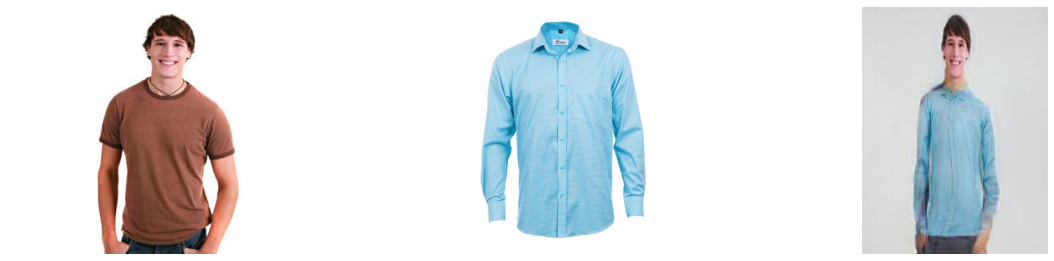

In [21]:
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
plt.figure(figsize=(20,10))

x = mpimg.imread('data/raw_data/image/model_to_dress.jpg')
y = mpimg.imread('data/raw_data/cloth/blue-shirt.jpg') 
z = mpimg.imread('result/model_to_dress.jpg') 

images = [x,y,z]

columns = 3
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.axis('off')
    plt.imshow(image)